# Superposed epoch analysis 

Try to decouple the large scale and small scale currents in the discontinuity.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polars as pl

from datetime import timedelta
from discontinuitypy.utils.basic import df2ts
from discontinuitypy.core.pipeline import compress_dfs_by_intervals
from xarray_einstats import linalg
from sea_norm import sean
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes

from discontinuitypy.integration import J_FACTOR

from utils import keep_good_fit

from loguru import logger

  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 85, in <module>
    from . import skintegrate
  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/skintegrate.py", line 20, in <module>
    from sklearn.base import BaseEstimator
ModuleNotFoundError: No module named 'sklearn'

  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 105, in <module>
    from . import nltk_stages
  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/nltk_stages.py", line 19, in <module>
    import nltk
ModuleNotFoundError: No module named 'nltk'



In [3]:
from discontinuitypy.propeties.mva import minvar
import numpy as np

def get_dBdt_data(data: pl.LazyFrame):
    """
    Calculate the time derivative of the magnetic field
    """
    # TODO: compress data first by events, however, this will decrease the reliability of the derivative at the edges of the events
    ts = df2ts(data)

    vec_diff = ts.differentiate("time", datetime_unit="s")
    vec_diff_mag: xr.DataArray = linalg.norm(vec_diff, dims="v_dim")
    return vec_diff_mag.to_dataframe(name="dBdt")

def _get_mva_data(
    data: pl.LazyFrame,
    start,
    end,
    columns=["B_l", "B_m", "B_n"],
    normalize=True,
):
    event_data = data.filter(pl.col("time") >= start, pl.col("time") <= end).collect()

    event_numpy = event_data.drop(
        "time"
    ).to_numpy()  # Assuming this is efficient for your use case
    time = event_data.get_column("time").to_numpy()

    vrot, _, _ = minvar(event_numpy)

    if True:
        vl = vrot[:, 0]
        vl = vl * np.sign(vl[-1] - vl[0])
        vl_ts = xr.DataArray(vl, dims="time", coords={"time": time})
        dvl_dt_df = vl_ts.differentiate("time", datetime_unit="s").to_dataframe(
            name="dBl_dt"
        )

    if normalize:
        vrot = normalize_mva_data(vrot)
        vrot_df = pd.DataFrame(vrot, columns=columns, index=time)

    return pd.concat([vrot_df, dvl_dt_df], axis=1)[1:-1]


def get_mva_data(
    data: pl.LazyFrame,
    starts: list,
    ends: list,
    **kwargs,
):
    """
    Get the MVA data for the given intervals
    """
    return pd.concat(
        _get_mva_data(data, start, end, **kwargs) for start, end in zip(starts, ends)
    )


def normalize_mva_data(
    data: np.ndarray, shift=False  # shift the data in l direction to the origin
):
    """
    normalize the MVA data: Bl, Bm, and Bn were respectively normalized to B0 = 0.5ΔBl, Bm, and <B>
    """
    vl, vm, vn = data.T

    vl_norm_q = (vl[-1] - vl[0]) / 2
    vm_norm_q = (vm[0] + vm[-1]) / 2
    vn_norm_q = (vn[0] + vn[-1]) / 2

    return np.array([vl / vl_norm_q, vm / vm_norm_q, vn / vn_norm_q]).T

In [4]:
def sea_ids(
    dfs: list[pl.LazyFrame],
    events: pl.DataFrame,
    start_col="t.d_start",
    end_col="t.d_end",
    event_cols=["t.d_start", "t.d_time", "t.d_end"],
    sea_cols=[
        "B_l",
        "j_m",
        "j_m_norm",
        "B_m",
    ],
    offset = timedelta(seconds=1),
    bins=[10, 10],
    return_data=True,
):

    if not isinstance(dfs, list):
        dfs = [dfs]

    events = keep_good_fit(events)

    sea_events = [col.to_numpy() for col in events[event_cols]]

    starts = events.get_column(start_col) - offset
    ends = events.get_column(end_col) + offset

    logger.info("Compressing data by events")
    data_c = compress_dfs_by_intervals(dfs, starts, ends).lazy()
    
    mva_data = get_mva_data(data_c, starts=starts, ends=ends)
    b_data = mva_data.sort_index()
    # dBdt_data = get_dBdt_data(data_c)
    # b_data = dBdt_data.join(mva_data, on="time")

    p_data = (
        events[["time", "v_k", "j_Alfven"]].to_pandas().set_index("time").sort_index()
    )

    sea_data = pd.merge_asof(
        b_data,
        p_data,
        left_index=True,
        right_index=True,
        direction="nearest",
    )

    sea_data = sea_data.assign(
        j_m=lambda df: df.dBl_dt / df.v_k * J_FACTOR,
        j_m_norm=lambda df: df.j_m / df.j_Alfven,
        # j_k=lambda df: df.dBdt / df.v_k * J_FACTOR,
        # j_k_norm=lambda df: df.j_k / df.j_Alfven,
    )

    return sean(sea_data, sea_events, bins, return_data=return_data, cols=sea_cols)

In [5]:
def plot_SEA(SEAarray: pd.DataFrame, meta) -> tuple[Figure, list[Axes]]:
    
    cols = meta["sea_cols"]
    fig, axes = plt.subplots(nrows=len(cols), sharex=True, squeeze=True)

    if len(cols) == 1:
        axes = [axes]

    # loop over columns that were analyzed
    for c, ax in zip(cols, axes):
        # for each column identify the column titles which
        # have 'c' in the title and those that don't have
        # 'cnt' in the title
        # e.g. for AE columns
        # AE_mean, AE_median, AE_lowq, AE_upq, AE_cnt
        # fine columns AE_mean, AE_median, AE_lowq, AE_upq
        # mask = SEAarray.columns.str.startswith(c) & ~SEAarray.columns.str.endswith("cnt")
        mask = [c + "_mean", c + "_median", c + "_lowq", c + "_upq"]
        style = ["r-", "b-", "b--", "b--"]
        
        # plot the SEA data
        SEAarray.loc[:, mask].plot(
            ax=ax,
            style=style,
            xlabel="Normalized Time",
            ylabel=c.replace("_", " "),
            legend=False,
        )

    return fig, axes

def plot_ids_sea(SEAarray: pd.DataFrame, meta) -> tuple[Figure, list[Axes]]:
    import scienceplots
    
    SEAarray.index = SEAarray.index.map(lambda x: x / bin/2)

    with plt.style.context(['science', 'nature', 'notebook']):

        fig, axes = plot_SEA(SEAarray, meta)

        axes[0].set_ylabel(r"$B_x \ / \ B_0$")
        axes[1].set_ylabel(r"$J_y$")
        axes[2].set_ylabel(r"$J_y \ / \ J_A$")
        axes[3].set_ylabel(r"$J_k$")
        axes[4].set_ylabel(r"$J_k \ / \ J_A$")
        axes[5].set_ylabel(r"$B_m \ / \ B_g$")

        fig.tight_layout()
        fig.subplots_adjust(hspace=0)
        
        axes[0].legend(labels=["Mean", "Median", "LowQ", "UpQ"])
    return fig, axes
    # fig.savefig(f"../../../figures/sea/sea_juno_first_year_{freq}.png", dpi = 300)


In [6]:
#| hide
from utils.config import JunoConfig

In [7]:
# config = JunoConfig(timerange=['2011-01-01','2012-01-01'], ts=1/8, split=16)
config = JunoConfig(timerange=['2011-01-01','2011-09-01'], ts=1/8, split=2)
ts_f = config.ts.total_seconds()

In [ ]:
ids_ds = config.get_and_process_data()

In [88]:
bin = 32

events = ids_ds.events.with_columns(r_bin=pl.col("radial_distance").round())

dfs = config.mag_dfs

SEAarrays = {}

for [r], r_events in events.group_by(["r_bin"]):
    SEAarray, meta, p1data, p2data = sea_ids(dfs, events=r_events, bins=[bin, bin])
    SEAarrays[r] = SEAarray
    
def func():
    for r, SEAarray in SEAarrays.items():
        yield pl.from_dataframe(SEAarray).with_columns(r_bin=r)

sea_df = pl.concat(func()).sort("r_bin")
sea_df.write_csv("../data/05_reporting/sea_juno_ts_{ts_f}.csv")

2024-02-25 01:00:43.955 | INFO     | __main__:sea_ids:28 - Compressing data by events
100%|██████████| 2150/2150 [00:01<00:00, 1959.71it/s]
2024-02-25 01:01:14.763 | INFO     | __main__:sea_ids:28 - Compressing data by events
100%|██████████| 2460/2460 [00:01<00:00, 2114.96it/s]
2024-02-25 01:01:47.126 | INFO     | __main__:sea_ids:28 - Compressing data by events


There is no data for event 11627


100%|██████████| 20562/20562 [00:10<00:00, 2037.43it/s]
2024-02-25 01:03:24.733 | INFO     | __main__:sea_ids:28 - Compressing data by events
100%|██████████| 9430/9430 [00:04<00:00, 2118.91it/s]
2024-02-25 01:04:19.989 | INFO     | __main__:sea_ids:28 - Compressing data by events
100%|██████████| 1776/1776 [00:00<00:00, 2127.65it/s]


IndexError: index 4 is out of bounds for axis 0 with size 4

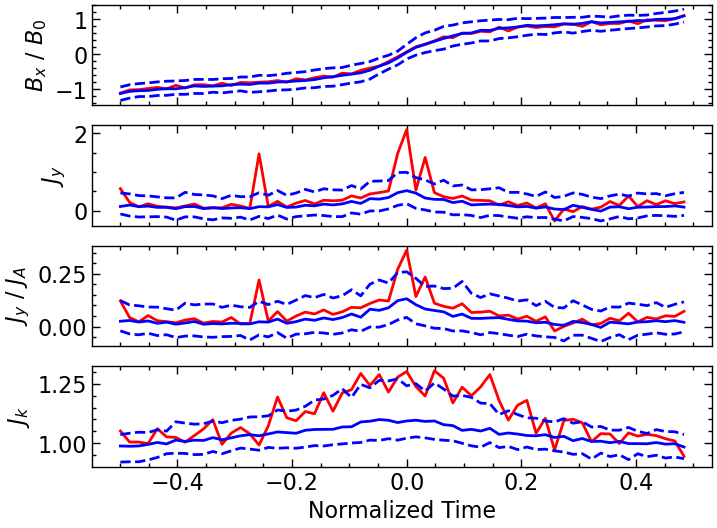

In [89]:
for r, SEAarray in SEAarrays.items():
    fig, axes = plot_ids_sea(SEAarray, meta)
    fig.show()
    fig.savefig(f"../figures/sea/sea_juno_ts_{ts_f}_{r}.png", dpi = 300)
    

### Fitting

In [142]:
import mygrad as mg
from lmfit import Model

In [143]:
def logistic(x, A, mu, sigma):
    alpha = (x - mu) / sigma
    return A * (1 - 1 / (1 + np.e**alpha))


def dfdx(x, A=1, mu=0, sigma=1):
    x = mg.tensor(np.array(x))
    f = logistic(x, A, mu, sigma)
    f.backward()
    return x.grad

comp_model = Model(dfdx, prefix="m1_") + Model(dfdx, prefix="m2_")
params = comp_model.make_params(
    m1_mu = dict(value=0, vary=False),
    m2_mu = dict(value=0, vary=False),
    m1_A = dict(value=0.5, min=0),
    m2_A = dict(value=0.2, min=0),
    m1_sigma = dict(value=1, min=0),
    m2_sigma = dict(value=2, min=0),
)

model = Model(dfdx)
params1 = model.make_params(
    A = dict(value=0.5, min=0),
    mu = dict(value=0, vary=False),
    sigma = dict(value=1, min=0),
)

In [150]:
from lmfit.model import ModelResult

def plot_result(x, y, result: ModelResult, result1=None, ax: Axes = None):
    # print(result.fit_report())
    x_plot = np.linspace(x.min(), x.max(), 1000)
    comps = result.eval_components(x=x_plot)
    
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x, y, "o")
    ax.plot(x_plot, result.eval(x=x_plot), label="best fit")
    ax.plot(x_plot, comps["m1_"], "--", label="comp#1 fit")
    ax.plot(x_plot, comps["m2_"], "--", label="comp#2 fit")
    if result1:
        ax.plot(x, result1.best_fit, label="best fit with one component")
    return ax

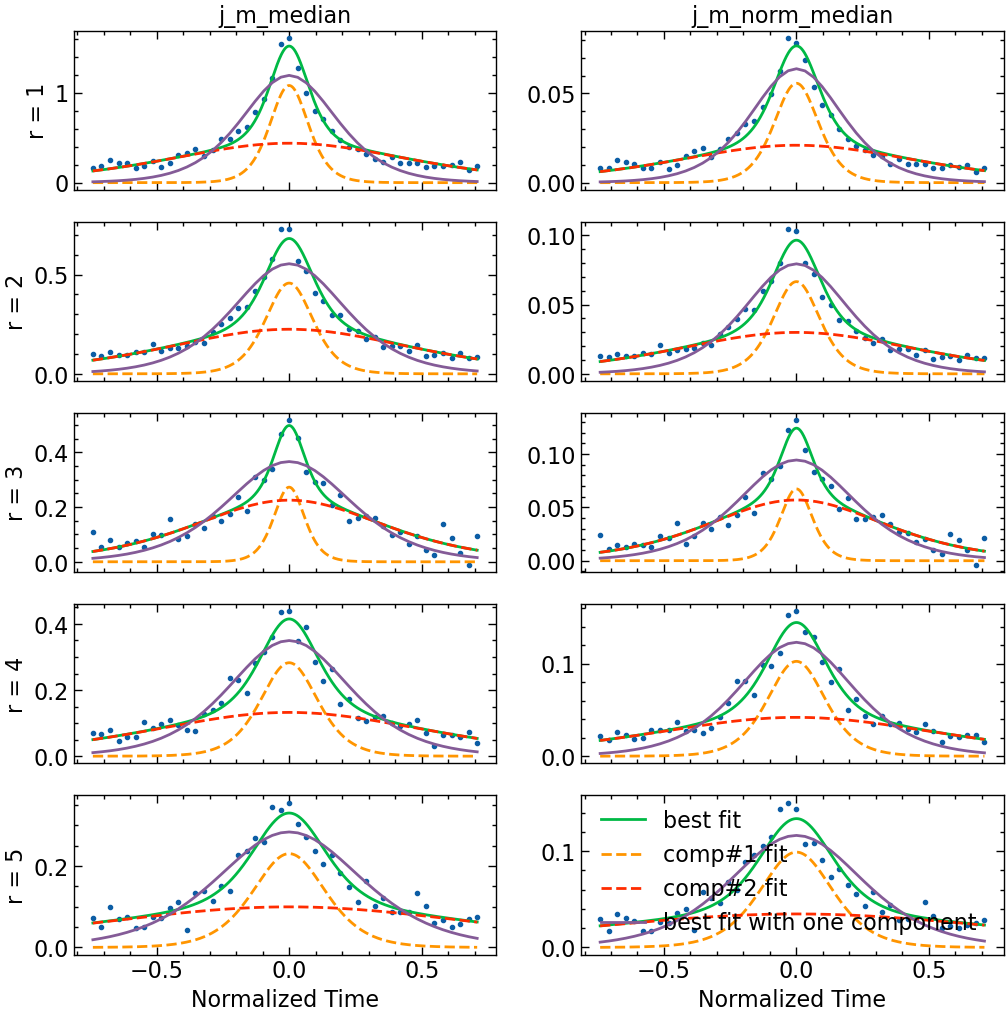

In [282]:
#| label: fig-fit
#| fig-cap: SEA analysis
x = SEAarray.index.values[8:-8]/bin
fit_cols = ["j_m_median", "j_m_norm_median"]
fit_result: list[ModelResult] = []
fit_result1: list[ModelResult] = []

SEAarrays = dict(sorted(SEAarrays.items()))

fig, axes = plt.subplots(len(SEAarrays), len(fit_cols), sharex=True, figsize=(12, 12))

for i, (r, SEAarray) in enumerate(SEAarrays.items()):
    for j, col in enumerate(fit_cols):
        y = SEAarray[col].values[8:-8]

        result = comp_model.fit(y, params, x=x)
        result_dict: dict = result.params.valuesdict()
        result_dict.update({"r": r, "col": col})
        fit_result.append(result_dict)

        result1 = model.fit(y, params1, x=x)
        result_dict1: dict = result1.params.valuesdict()
        result_dict1.update({"r": r, "col": col})
        fit_result1.append(result_dict1)
        
        ax :Axes = axes[i, j]
        plot_result(x, y, result, result1, ax=ax)
        
        if i == 0:
            ax.set_title(f"{col}")
        if j == 0:
            ax.set_ylabel(f"r = {r:.0f}")
        
        if i == len(SEAarrays) - 1:
            ax.set_xlabel("Normalized Time")
        
axes.flatten()[-1].legend()

fit_result_df = pd.DataFrame(fit_result).sort_values('r')
fit_result1_df = pd.DataFrame(fit_result1).sort_values('r')

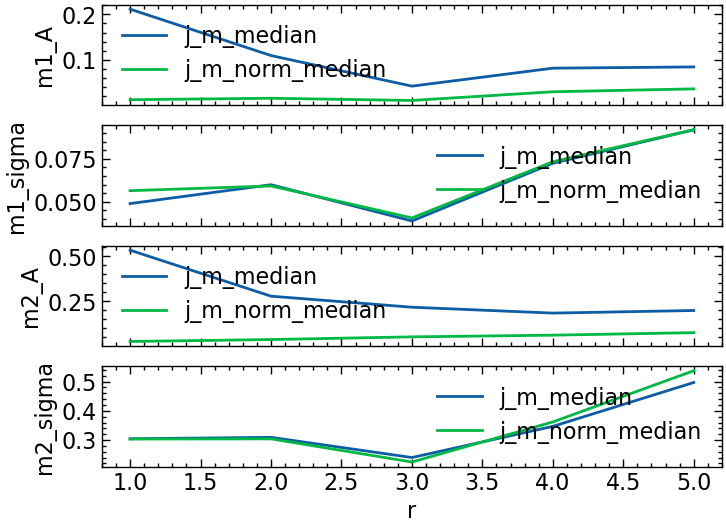

In [283]:
#| label: fig-fit-params
#| fig-cap: Fit parameters over the radial distance
ys = ['m1_A', 'm1_sigma', 'm2_A', 'm2_sigma']
fig, axes = plt.subplots(nrows=len(ys), sharex=True)
axes : list[Axes]
for param, ax in zip(ys, axes):
    group_df = fit_result_df.groupby('col')
    for name, group in group_df:
        group.plot(x='r',y=param, ax=ax, label=name)
    ax.set_ylabel(param)

plt.legend()

# fit_result_df['m2_sigma'].plot()

In [127]:
def dvl_dt(
    data: pl.LazyFrame,
    start,
    end,
):
    event_data = data.filter(pl.col("time") >= start, pl.col("time") <= end).collect()

    event_numpy = event_data.drop("time").to_numpy()
    time = event_data.get_column("time").to_numpy()

    vrot, _, _ = minvar(event_numpy)

    vl = vrot[:, 0]
    vl = vl * np.sign(vl[-1] - vl[0])
    vl_ts = xr.DataArray(vl, dims="time", coords={"time": time})

    return vl_ts.differentiate("time", datetime_unit="s")

def ids_j_bin_l(
    events: pl.DataFrame,
    dfs: list[pl.LazyFrame],
    start_col="t.d_start",
    end_col="t.d_end",
    offset=timedelta(seconds=1),
):

    if not isinstance(dfs, list):
        dfs = [dfs]

    events = keep_good_fit(events)

    starts = events.get_column(start_col) - offset
    ends = events.get_column(end_col) + offset

    logger.info("Compressing data by events")
    data_c = compress_dfs_by_intervals(dfs, starts, ends).lazy()

    logger.info("Calculating dvl_dt")
    return (
        dvl_dt(data_c, start, end) for start, end in zip(starts, ends)
    )

In [145]:
dvl_dts = list(ids_j_bin_l(events, config.mag_dfs))

2024-02-25 15:05:05.917 | INFO     | __main__:ids_j_bin_l:35 - Compressing data by events
2024-02-25 15:05:05.982 | INFO     | __main__:ids_j_bin_l:38 - Calculating dvl_dt


In [146]:
def func():
    epochs = events.get_column("t.d_time").to_numpy()
    v_ks = events.get_column("v_k")
    ion_inertial_lengths = events.get_column("ion_inertial_length")
    rs = events.get_column("radial_distance")
    
    for i, dvl_dt in enumerate(dvl_dts):
        shift_time = (dvl_dt.time - epochs[i]).values.astype(float)
        l_norm = shift_time / 1.0e9 * v_ks[i] / ion_inertial_lengths[i]
        # yield l_norm.values.astype(float)
        yield rs[i], l_norm, dvl_dt.values

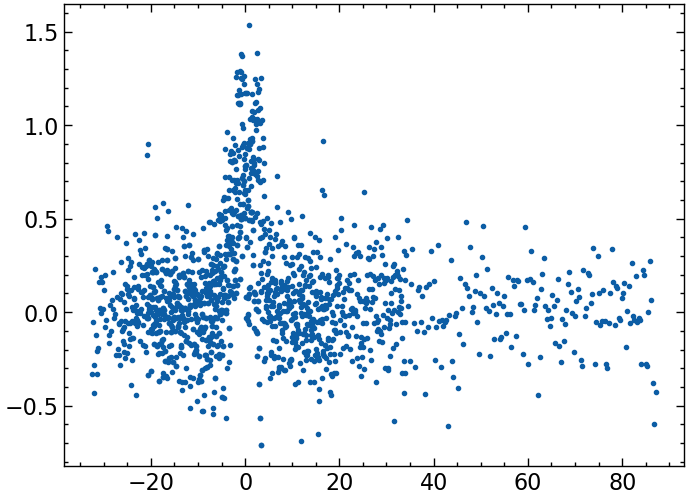

In [147]:
rs, ls, dvl_dts = zip(*func())
ls_all = np.concatenate(ls)
dvl_dts_all = np.concatenate(dvl_dts)
plt.scatter(ls_all, dvl_dts_all)

<Axes: >

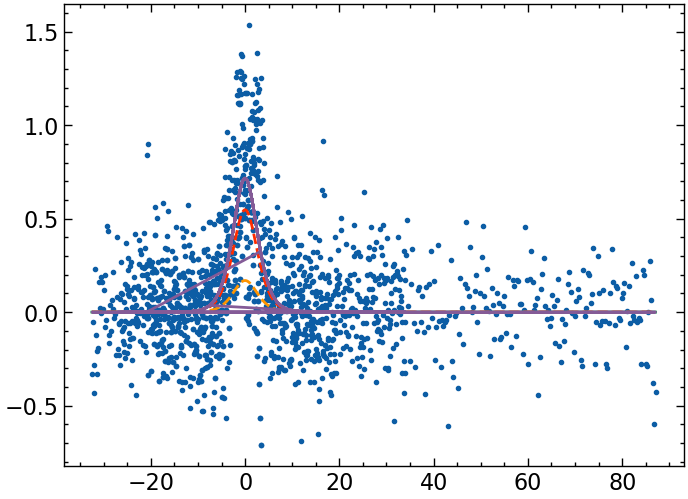

In [153]:
y = dvl_dts_all
x = ls_all
result = comp_model.fit(y, params, x=x)
result1 = model.fit(y, params1, x=x)

plot_result(x, y, result, result1)

In [19]:
events = ids_ds.events.head(10).pipe(ids_j_bin_l, dfs=config.mag_dfs[0]).with_columns(r_bin=pl.col("radial_distance").round())

2024-02-25 14:23:30.016 | INFO     | __main__:ids_j_bin_l:44 - Compressing data by events
2024-02-25 14:23:30.068 | INFO     | __main__:ids_j_bin_l:47 - Calculating dvl_dt


In [28]:
events.select(
    pl.col("times").list
)

times
list[i64]
"[1314285913062500000, 1314285913187500000, … 1314285944187500000]"
"[1314286368812500000, 1314286368937500000, … 1314286403312500000]"
"[1314286385562500000, 1314286385687500000, … 1314286424312500000]"
"[1314287645562500000, 1314287645687500000, … 1314287690437500000]"
"[1314292230062500000, 1314292230187500000, … 1314292253812500000]"
"[1314292230062500000, 1314292230187500000, … 1314292253812500000]"


#### Superposed epoch analysis

In [ ]:
groupby = 'index'
columns = ['dBdt', 'j_k']

# Plot each group
fig, axes = plt.subplots(nrows=len(columns))

if len(columns) == 1:
    axes = [axes]

p1groups = p1data.groupby(groupby)
p2groups = p2data.groupby(groupby)

for ax, column in zip(axes, columns):
    for name, group in p1groups:
        ax.plot(group['t_norm'] -1 , group[column], color='grey', alpha=0.3)
        
    for name, group in p2groups:
        ax.plot(group['t_norm'], group[column], color='grey', alpha=0.3)

# plt.yscale('log')
plt.show()


In [ ]:
#| layout-ncol: 3
#| column: page
ids_ds.plot_candidates(num=20, plot_fit_data=True, predicates=(pl.col('fit.stat.rsquared') > 0.95))
